In [ ]:
import sklearn
import os
from tqdm.autonotebook import tqdm
import numpy as np
from PIL import Image
import pandas as pd
from google.colab.patches import cv2_imshow
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential, load_model, Model 
from keras.layers import Conv2D, MaxPool2D, Add, Dense, Reshape, Flatten, Dropout, BatchNormalization, ReLU, Activation, Concatenate, Flatten, Input, Concatenate, Activation, LSTM, Bidirectional, Lambda
from keras import Input
from keras import backend
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# check GPU
!nvidia-smi

Tue Mar 22 15:12:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Load dataset
# 7765 images  
data = []
for i in tqdm(range(1, 7766), desc="Loading data..."):
  path = '/content/gdrive/MyDrive/DatasetDoAn2/Handwritting Digit/' + str(i) + '.jpg'
  image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  image = cv2.resize(image, (100, 40))  # width height
  data.append(image)
print("Completed!")
data = np.array(data, dtype="float32")
data = data / 255.0

Loading data...:   0%|          | 0/7765 [00:00<?, ?it/s]

Completed!


In [ ]:
# Load labels
labels = []
df = pd.read_excel('/content/gdrive/MyDrive/DatasetDoAn2/Annotation.xlsx', dtype=np.str)
for i in df.index:
    #labels.append(str(df['Label'][i]))
    str1 = str(df['Label'][i])
    if str1 == '0':
      str2 = 'nnnnn'
    if len(str1) == 3:
      str2 = 'n' + str1 + 'n'
    if len(str1) == 4:
      str2 = str1 + 'n'
    labels.append(str2)
labels = np.array(labels)
labels

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


array(['nnnnn', 'n8.0n', 'n1.5n', ..., 'n6.0n', 'nnnnn', 'n7.0n'],
      dtype='<U5')

In [ ]:
characters = u"0123456789.n"
max_length = max([len(label) for label in labels])
print('Max length of labels: ', max_length)
print('Characters: ', characters)

Max length of labels:  5
Characters:  0123456789.n


In [ ]:
# Characters to numbers
def label_to_num(label):
  num = []
  for character in label:
    num.append(characters.find(character))  
  return np.array(num)

# Numbers to characters  
def num_to_label(num):
  label = ""
  for ch in num:
    if ch == -1:  
      break
    else:
      label += characters[ch]
  return label

In [ ]:
# Encode all labels to numbers
tmp_labels = []
for i in range (0, len(labels)):
  label = label_to_num(labels[i])
  tmp_labels.append(label)
labels = tmp_labels
labels = np.array(labels)

In [ ]:
# Split dataset
X_train_val, X_test, Y_train_val, Y_test = train_test_split(data, labels, test_size=0.05)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.2)

In [ ]:
input_img = Input(shape=(40, 100 , 1), name="input")

x = Conv2D(filters=32, kernel_size=(3,3), activation="linear", padding="same")(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

# Residual block 1
x1 = Conv2D(filters=32, kernel_size=(3,3), strides=1, activation="linear", padding="same")(x)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)
x1 = Conv2D(filters=32, kernel_size=(3,3), strides=1, activation="linear", padding="same")(x1)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)
x2 = Conv2D(filters=32, kernel_size=(3,3), strides=1, activation="linear", padding="same")(x)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)
x = Add()([x1, x2])

# Residual block 2
x1 = Conv2D(filters=64, kernel_size=(3,3), strides=1, activation="linear", padding="same")(x)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)
x1 = Conv2D(filters=64, kernel_size=(3,3), strides=1, activation="linear", padding="same")(x1)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)
x2 = Conv2D(filters=64, kernel_size=(3,3), strides=1, activation="linear", padding="same")(x)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)
x = Add()([x1, x2])

# Residual block 3
x1 = Conv2D(filters=64, kernel_size=(3,3), strides=1, activation="linear", padding="same")(x)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)
x1 = Conv2D(filters=64, kernel_size=(3,3), strides=1, activation="linear", padding="same")(x1)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)
x2 = Conv2D(filters=64, kernel_size=(3,3), strides=1, activation="linear", padding="same")(x)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)
x = Add()([x1, x2])

# Residual block 4
x1 = Conv2D(filters=128, kernel_size=(3,3), strides=1, activation="linear", padding="same")(x)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)
x1 = Conv2D(filters=128, kernel_size=(3,3), strides=1, activation="linear", padding="same")(x1)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)
x2 = Conv2D(filters=128, kernel_size=(3,3), strides=1, activation="linear", padding="same")(x)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)
x = Add()([x1, x2])
#Reshape and fed to RNN 
new_shape = (x.shape[1], x.shape[2] * 128)
x = Reshape(target_shape=new_shape, name="reshape")(x)
x = Dense(64, activation='relu', kernel_initializer='he_normal')(x)
x = Bidirectional(LSTM(256, return_sequences=True))(x)
x = Bidirectional(LSTM(256, return_sequences=True))(x)
y_pred = Dense(units=len(characters) + 1, activation="softmax")(x)

model = Model(inputs=input_img, outputs=y_pred)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 40, 100, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 40, 100, 32)  320         ['input[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 40, 100, 32)  128        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [ ]:
labels = Input(name='gtruth_labels', shape=[5], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_ctc = Model(inputs=[input_img, labels, input_length, label_length], outputs=ctc_loss)
# Model bao gồm ảnh input_img, nhãn labels, độ dài sequence input_length, độ dài nhãn label_length 

In [ ]:
num_of_characters = len(characters) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 20

train_label_len = np.zeros([Y_train.shape[0], 1])
train_input_len = np.ones([Y_train.shape[0], 1]) * (num_of_timestamps-2)
train_output = np.zeros([Y_train.shape[0]])
for i in range (train_label_len.shape[0]):
  train_label_len[i] = 5


val_label_len = np.zeros([Y_val.shape[0], 1])
val_input_len = np.ones([Y_val.shape[0], 1]) * (num_of_timestamps-2)
val_output = np.zeros([Y_val.shape[0]])
for i in range (val_label_len.shape[0]):
  val_label_len[i] = 5

In [ ]:
opt = keras.optimizers.Adam(learning_rate = 0.0001)
model_ctc.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=opt, metrics=['accuracy'])
train = model_ctc.fit(x=[X_train, Y_train, train_input_len, train_label_len], y=train_output, validation_data=([X_val, Y_val, val_input_len, val_label_len], val_output), epochs=50, batch_size=32)

Epoch 1/50
185/185 [==============================] - 52s 168ms/step - loss: 6.6355 - accuracy: 0.0000e+00 - val_loss: 14.3909 - val_accuracy: 0.0000e+00
Epoch 2/50
185/185 [==============================] - 28s 151ms/step - loss: 2.2612 - accuracy: 0.0044 - val_loss: 16.1841 - val_accuracy: 0.0000e+00
Epoch 3/50
185/185 [==============================] - 28s 150ms/step - loss: 1.0923 - accuracy: 0.3614 - val_loss: 1.6725 - val_accuracy: 0.1802
Epoch 4/50
185/185 [==============================] - 28s 150ms/step - loss: 0.5591 - accuracy: 0.7146 - val_loss: 0.4811 - val_accuracy: 0.7724
Epoch 5/50
185/185 [==============================] - 28s 151ms/step - loss: 0.3588 - accuracy: 0.8097 - val_loss: 0.7844 - val_accuracy: 0.6775
Epoch 6/50
185/185 [==============================] - 28s 150ms/step - loss: 0.2887 - accuracy: 0.8407 - val_loss: 0.3645 - val_accuracy: 0.8238
Epoch 7/50
185/185 [==============================] - 29s 155ms/step - loss: 0.2188 - accuracy: 0.8653 - val_loss: 0

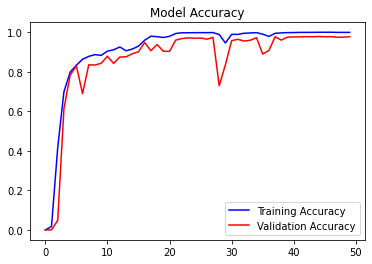

In [ ]:
accuracy = train.history['accuracy']
val_accuracy = train.history['val_accuracy']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

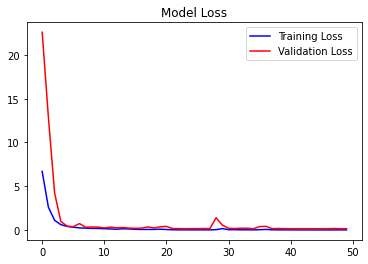

In [ ]:
train_loss = train.history['loss']
val_loss = train.history['val_loss']
epochs = range(len(train_loss))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

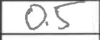

Predicted:  00.5  
True Label: 0.5


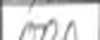

Predicted:  010  
True Label: 000


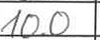

Predicted:  010.0  
True Label: 10.0


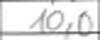

Predicted:  010.0  
True Label: 10.0


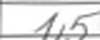

Predicted:  01.5  
True Label: 1.5


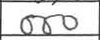

Predicted:  000.0  
True Label: 000


In [ ]:
for i in range(0, 389):
  img = X_test[i]
  pred = model.predict(img.reshape(1, 40, 100, 1))
  decoded = backend.get_value(backend.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], greedy=True)[0][0])
  label = num_to_label(decoded[0])
  img = img * 255
  label = label.replace("n", "")
  true_label = num_to_label(Y_test[i])
  true_label = true_label.replace("n", "")
  if label != true_label:
    cv2_imshow(img)
    print('Predicted: ', label, ' \nTrue Label:', true_label)

In [ ]:
model_CRNNCTC = model.to_json()
with open("/content/gdrive/MyDrive/DatasetDoAn2/Model/model_CRNNCTC_final.json", "w") as json_file:
    json_file.write(model_CRNNCTC)
model.save_weights("/content/gdrive/MyDrive/DatasetDoAn2/Model/model_CRNNCTC_final.h5")

In [ ]:
from keras.models import model_from_json, Sequential
with open('/content/gdrive/MyDrive/DatasetDoAn2/Model/model_CRNNCTC_final.json', 'r') as json_file:
  model_json = json_file.read()
model = model_from_json(model_json)
model.load_weights('/content/gdrive/MyDrive/DatasetDoAn2/Model/model_CRNNCTC_final.h5')

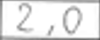

n2.0n


In [ ]:
img = cv2.imread('/content/gdrive/MyDrive/DatasetDoAn2/Digit/5.png', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (100, 40))
tensor = img / 255.0
pred = model.predict(tensor.reshape(1, 40, 100, 1))
decoded = backend.get_value(backend.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], greedy=True)[0][0])
label = num_to_label(decoded[0])
cv2_imshow(img)
print(label)